# 擬似相関チュートリアル Part 3: 因果探索（LiNGAM）による構造推定

## チュートリアル全体の構成
1. [擬似相関とは & データの準備](01_spurious_correlation_intro.ipynb)
2. [SHAP による特徴量重要度分析](02_shap_analysis.ipynb)
3. **因果探索（LiNGAM）による構造推定** (このノートブック)
4. [非線形関係における擬似相関の判別](04_nonlinear_verification.ipynb)
5. [まとめと使い分けガイドライン](05_summary.ipynb)

---
## 共通セットアップ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams['font.family'] = 'Meiryo'
matplotlib.rcParams['axes.unicode_minus'] = False

df = pd.read_csv('dataset.csv')

DIRECT_CAUSES = ['X', 'M', 'M2', 'Z1', 'Z2', 'Z3', 'D1']
SPURIOUS_CORR = ['N1', 'N4', 'N5', 'N7']
INDEPENDENT   = ['N2', 'N3', 'N6']
UPSTREAM      = ['W1', 'W2', 'IV', 'IV2', 'P1']
features = [c for c in df.columns if c != 'Y']

print(f'データサイズ: {df.shape}')

データサイズ: (2000, 20)


---
## 5. 因果探索（LiNGAM）による構造推定

LiNGAM (Linear Non-Gaussian Acyclic Model) は、データから因果構造を推定する手法です。
SHAP と異なり、変数間の**因果の方向**を識別できます。

In [2]:
import lingam

# DirectLiNGAM で因果構造を推定
model = lingam.DirectLiNGAM()
model.fit(df.values)

# 隣接行列を取得 (adj_matrix[i, j] = j→i の因果効果)
adj_matrix = model.adjacency_matrix_
columns = list(df.columns)
y_idx = columns.index('Y')

# Y への直接因果効果を抽出
causal_effects_on_Y = pd.Series(
    adj_matrix[y_idx, :],
    index=columns
).drop('Y').sort_values(key=abs, ascending=False)

print('=== LiNGAM: Y への推定因果効果 (直接) ===')
for feat, effect in causal_effects_on_Y.items():
    tag = ''
    if feat in DIRECT_CAUSES:
        tag = ' ✓ 直接原因'
    elif feat in SPURIOUS_CORR:
        tag = ' ⚠️ 擬似相関'
    elif feat in INDEPENDENT:
        tag = ' (独立ノイズ)'
    elif feat in UPSTREAM:
        tag = ' (上流変数)'
    marker = '***' if abs(effect) > 0.1 else '   '
    print(f'  {marker} {feat:4s}: {effect:+.4f}{tag}')

=== LiNGAM: Y への推定因果効果 (直接) ===
  *** M   : +1.3770 ✓ 直接原因
  *** D1  : +0.7262 ✓ 直接原因
  *** M2  : +0.5599 ✓ 直接原因
  *** Z1  : +0.3698 ✓ 直接原因
  *** W2  : +0.2313 (上流変数)
  *** X   : +0.2223 ✓ 直接原因
  *** P1  : -0.1792 (上流変数)
      W1  : +0.0000 (上流変数)
      IV2 : +0.0000 (上流変数)
      Z3  : +0.0000 ✓ 直接原因
      IV  : +0.0000 (上流変数)
      Z2  : +0.0000 ✓ 直接原因
      N1  : +0.0000 ⚠️ 擬似相関
      N2  : +0.0000 (独立ノイズ)
      N3  : +0.0000 (独立ノイズ)
      N4  : +0.0000 ⚠️ 擬似相関
      N5  : +0.0000 ⚠️ 擬似相関
      N6  : +0.0000 (独立ノイズ)
      N7  : +0.0000 ⚠️ 擬似相関


In [3]:
# Bootstrap で推定の安定性を確認
bs_result = model.bootstrap(df.values, n_sampling=100)

# Y への因果効果の確率（bootstrap）
probs = bs_result.get_probabilities(min_causal_effect=0.01)
probs_df = pd.DataFrame(probs, index=columns, columns=columns)

# 各変数 → Y の因果エッジ確率
edge_probs_to_Y = probs_df.loc['Y'].drop('Y').sort_values(ascending=False)

print('=== Bootstrap: 各変数 → Y のエッジ検出確率 ===')
for feat, prob in edge_probs_to_Y.items():
    tag = ''
    if feat in DIRECT_CAUSES:
        tag = ' ✓ 直接原因'
    elif feat in SPURIOUS_CORR:
        tag = ' ⚠️ 擬似相関'
    bar = '█' * int(prob * 20)
    print(f'  {feat:4s}: {prob:.2f} {bar}{tag}')

=== Bootstrap: 各変数 → Y のエッジ検出確率 ===
  D1  : 0.81 ████████████████ ✓ 直接原因
  M2  : 0.74 ██████████████ ✓ 直接原因
  Z2  : 0.63 ████████████ ✓ 直接原因
  IV  : 0.54 ██████████
  IV2 : 0.53 ██████████
  Z3  : 0.53 ██████████ ✓ 直接原因
  X   : 0.51 ██████████ ✓ 直接原因
  M   : 0.50 ██████████ ✓ 直接原因
  Z1  : 0.49 █████████ ✓ 直接原因
  P1  : 0.46 █████████
  W2  : 0.41 ████████
  N1  : 0.28 █████ ⚠️ 擬似相関
  W1  : 0.22 ████
  N5  : 0.20 ████ ⚠️ 擬似相関
  N7  : 0.17 ███ ⚠️ 擬似相関
  N4  : 0.16 ███ ⚠️ 擬似相関
  N2  : 0.10 ██
  N3  : 0.05 █
  N6  : 0.02 


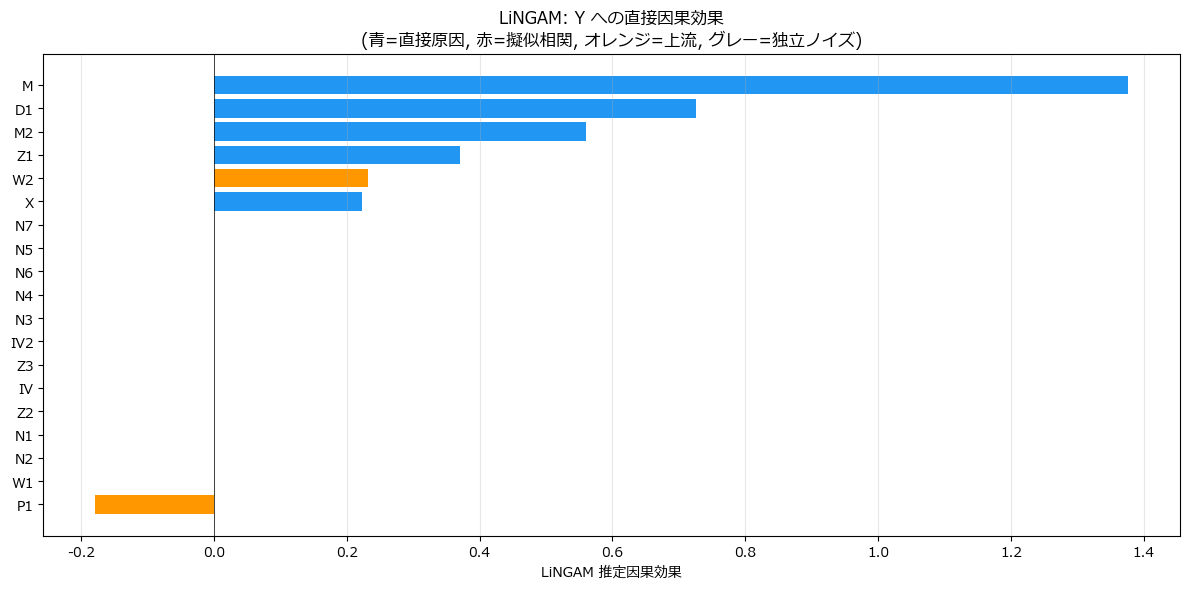

In [4]:
# 因果効果の可視化
fig, ax = plt.subplots(figsize=(12, 6))

sorted_effects = causal_effects_on_Y.sort_values(ascending=True)

colors_causal = []
for feat in sorted_effects.index:
    if feat in DIRECT_CAUSES:
        colors_causal.append('#2196F3')
    elif feat in SPURIOUS_CORR:
        colors_causal.append('#F44336')
    elif feat in INDEPENDENT:
        colors_causal.append('#9E9E9E')
    else:
        colors_causal.append('#FF9800')

ax.barh(range(len(sorted_effects)), sorted_effects.values, color=colors_causal)
ax.set_yticks(range(len(sorted_effects)))
ax.set_yticklabels(sorted_effects.index)
ax.set_xlabel('LiNGAM 推定因果効果')
ax.set_title('LiNGAM: Y への直接因果効果\n(青=直接原因, 赤=擬似相関, オレンジ=上流, グレー=独立ノイズ)')
ax.axvline(x=0, color='black', linewidth=0.5)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

---
## 6. 比較: SHAP重要度 vs 因果効果

SHAP 重要度と LiNGAM 因果効果を並べて比較します。

SHAP の結果を再計算して比較に使用します。

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import shap

# SHAP 重要度を計算
X_all = df[features]
y = df['Y']
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.3, random_state=42)
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap_importance = pd.Series(
    np.abs(shap_values).mean(axis=0), index=features
).sort_values(ascending=False)

# 比較表の作成
comparison = pd.DataFrame({
    'SHAP重要度': shap_importance,
    'LiNGAM因果効果': causal_effects_on_Y.abs(),
    'SHAP順位': shap_importance.rank(ascending=False).astype(int),
    'LiNGAM順位': causal_effects_on_Y.abs().rank(ascending=False).astype(int),
}).sort_values('SHAP重要度', ascending=False)

def categorize(feat):
    if feat in DIRECT_CAUSES: return '直接原因'
    if feat in SPURIOUS_CORR: return '擬似相関'
    if feat in INDEPENDENT: return '独立ノイズ'
    return '上流変数'

comparison['カテゴリ'] = [categorize(f) for f in comparison.index]
comparison['順位差'] = (comparison['SHAP順位'] - comparison['LiNGAM順位']).abs()

print('=== SHAP重要度 vs LiNGAM因果効果 比較表 ===')
print(comparison.to_string())

print(f'\n--- 順位差が大きい変数 (SHAP と LiNGAM で評価が異なる) ---')
big_diff = comparison[comparison['順位差'] >= 5].sort_values('順位差', ascending=False)
for feat, row in big_diff.iterrows():
    print(f'  {feat}: SHAP {int(row["SHAP順位"])}位 vs LiNGAM {int(row["LiNGAM順位"])}位'
          f'  (差: {int(row["順位差"])}) [{row["カテゴリ"]}]')

=== SHAP重要度 vs LiNGAM因果効果 比較表 ===
      SHAP重要度  LiNGAM因果効果  SHAP順位  LiNGAM順位   カテゴリ  順位差
M    1.390207    1.377011       1         1   直接原因    0
D1   0.456713    0.726235       2         2   直接原因    0
X    0.341664    0.222255       3         6   直接原因    3
M2   0.207732    0.559902       4         3   直接原因    1
Z3   0.103667    0.000000       5        13   直接原因    8
Z1   0.087251    0.369840       6         4   直接原因    2
N7   0.063944    0.000000       7        13   擬似相関    6
Z2   0.040504    0.000000       8        13   直接原因    5
N1   0.033542    0.000000       9        13   擬似相関    4
N4   0.032814    0.000000      10        13   擬似相関    3
W1   0.030232    0.000000      11        13   上流変数    2
P1   0.025430    0.179163      12         7   上流変数    5
N5   0.008889    0.000000      13        13   擬似相関    0
N6   0.006544    0.000000      14        13  独立ノイズ    1
N3   0.006272    0.000000      15        13  独立ノイズ    2
N2   0.006090    0.000000      16        13  独立ノイズ    3
W2   0.003496 

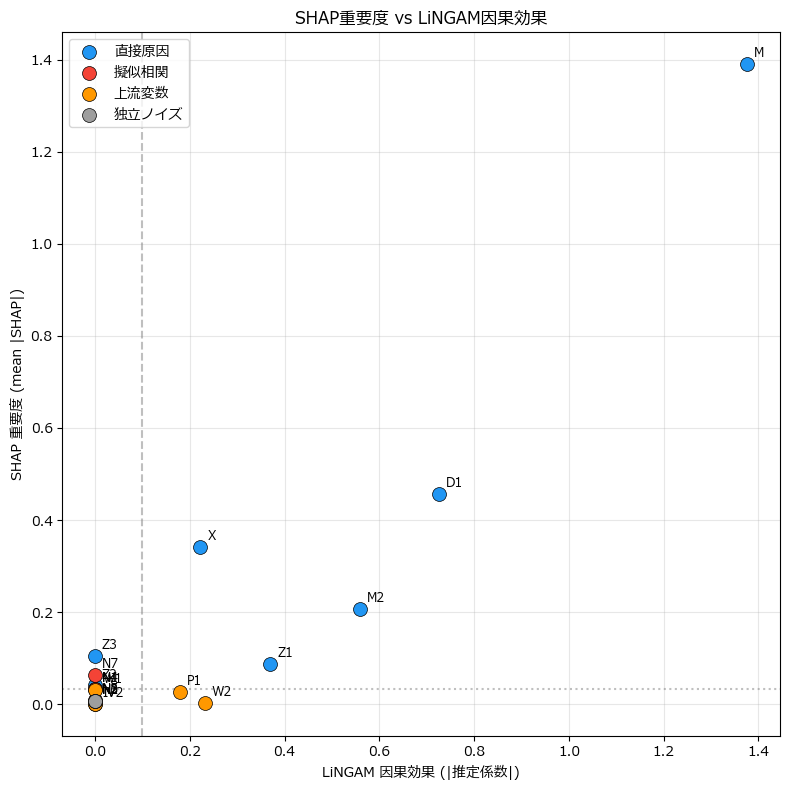

--- 読み方 ---
右上 (因果効果 大 & SHAP 高): 正しく重要と判定された直接原因
左上 (因果効果 小 & SHAP 高): SHAP に過大評価された擬似相関変数 ← 注意!
右下 (因果効果 大 & SHAP 低): SHAP に過小評価された因果変数
左下 (因果効果 小 & SHAP 低): 正しく不要と判定されたノイズ


In [6]:
# 散布図: SHAP重要度 vs LiNGAM因果効果
fig, ax = plt.subplots(figsize=(8, 8))

color_map = {
    '直接原因': '#2196F3',
    '擬似相関': '#F44336',
    '上流変数': '#FF9800',
    '独立ノイズ': '#9E9E9E',
}

for cat, color in color_map.items():
    mask = comparison['カテゴリ'] == cat
    subset = comparison[mask]
    ax.scatter(subset['LiNGAM因果効果'], subset['SHAP重要度'],
              c=color, s=100, label=cat, edgecolors='black', linewidth=0.5, zorder=3)
    for feat, row in subset.iterrows():
        ax.annotate(feat, (row['LiNGAM因果効果'], row['SHAP重要度']),
                   textcoords='offset points', xytext=(5, 5), fontsize=9)

ax.set_xlabel('LiNGAM 因果効果 (|推定係数|)')
ax.set_ylabel('SHAP 重要度 (mean |SHAP|)')
ax.set_title('SHAP重要度 vs LiNGAM因果効果')
ax.legend(loc='upper left')
ax.grid(alpha=0.3)

ax.axvline(x=0.1, color='gray', linestyle='--', alpha=0.5, label='因果効果閾値')
ax.axhline(y=comparison['SHAP重要度'].median(), color='gray', linestyle=':',
           alpha=0.5)

plt.tight_layout()
plt.show()

print('--- 読み方 ---')
print('右上 (因果効果 大 & SHAP 高): 正しく重要と判定された直接原因')
print('左上 (因果効果 小 & SHAP 高): SHAP に過大評価された擬似相関変数 ← 注意!')
print('右下 (因果効果 大 & SHAP 低): SHAP に過小評価された因果変数')
print('左下 (因果効果 小 & SHAP 低): 正しく不要と判定されたノイズ')

---
次のノートブック: [04_nonlinear_verification.ipynb](04_nonlinear_verification.ipynb) で非線形関係における擬似相関の判別を検証します。